# Audio source separation using visual motion information

Several studies in the field of neuroscience have established how the correlations between audio and motion  are utilized by the human brain to segregate sound sources, especially in noisy environments (Krishnan et al., 2014). This notebook provides a look into a particular multimodal formulation within the NMF framework that aims to segregate audio sources using corresponding motion information. Herein the cost functions for audio factorization and cross-modal sparse nonnegative least squares are simultaneously minimized. 

$$\newcommand{\reals}{\mathbb{R}}
\newcommand{\Va}{{\mathbf{V}}}
\newcommand{\Ha}{{\mathbf{H}}}
\newcommand{\Wa}{{\mathbf{W}}} 
\newcommand{\vel}{{\mathbf M}}
\newcommand{\malpha}{{\mathbf A}}
\newcommand{\vapprox}{{\mathbf \Lambda}}$$ 

### Notations

- $\Va \approx  \Wa\Ha$, where $\Wa =(w_{fk})_{f,k}  \in \mathbb{R}_{+}^{F \times K}$ and $\Ha =(h_{kn})_{k,n} \in \mathbb{R}_{+}^{K \times N}$ are interpreted as the nonnegative audio spectral patterns and their activation matrices respectively.
- $\vel \in  \mathbb{R}_+^{N \times C}$: Velocity matrix with each velocity vector arranged into columns as $[m_1 ~ m_2 \ldots m_C]$
	
- $\malpha \in \mathbb{R}_+^{K \times C}$: Nonnegative weight vector for taking linear combinations of $\Ha$, with each column denoted by $\alpha_c$ where $c \in \{1,C\}$ 
	



### Derivation

We formulate the following cost function as:
\begin{equation*}
\begin{aligned}
& C(\Wa, \Ha, \malpha)&= D_{KL} (\Va|\Wa\Ha) + \frac{\lambda}{2}\|\vel - \Ha^\intercal \malpha\|_2^2 + \mu \|\malpha\|_1
\end{aligned}
\end{equation*}

where $D_{KL}(.|.)$ is the Kullback-Leibler divergence and $\lambda$ is a regularization parameter.
Note that it is trivial to minimize the cost function in absence of scaling constraints:  $C(\eta\Wa, \Ha/\eta, \malpha\eta) < C(\Wa, \Ha, \malpha)$. Taking $\eta$ close to zero would lead to degenerate solutions. Therefore, we constrain the columns of $\Wa$ to have unit norm i.e. we construct $\widetilde{\Wa} = \left[\frac{w_{1}}{\|w_{1}\|}~ \frac{w_{2}}{\|w_{2}\|} \ldots \frac{w_{K}}{\|w_{K}\|} \right]$ and incorporate this into the cost function as: 

\begin{equation}
\label{cost-joint}
\begin{aligned}
& \underset{\Wa, \Ha, \malpha}{\text{minimize}}
& & \underbrace{D_{KL} (\Va|\widetilde{\Wa}\Ha)}_{\text{Audio Factorization}} + \underbrace{\frac{\lambda}{2}\|\vel - \Ha^\intercal \malpha\|_2^2 + \mu \|\malpha\|_1}_{\text{Sparse NNLS}}
\end{aligned}
\end{equation}

For convenience we will use $\Lambda = \widetilde{\Wa}\Ha$.

#### Preliminaries
NMF multiplicative updates can be obtained using the following heuristic approach: the derivative of the 
$\beta$--divergence with respect to a particular coefficient $\gamma$ of $\mathbf{W}$ or $\mathbf{H}$ can be written as 
a difference of two nonnegative functions, $\nabla D (\gamma) = \nabla D ^{+}(\gamma) - \nabla D ^{-}(\gamma)$. The update can then be written as:

\begin{equation}
\label{murule}
    \gamma \leftarrow \gamma\frac{\nabla D ^{-}(\gamma)}{\nabla D ^{+}(\gamma)}
\end{equation}

**Note**: A more principled approach to arrive at a solution for such optimization problems is provided by the 
majorization--minimization technique. This requires construction and minimization of an auxiliary function that is an upper--bound of the original cost function, tight at the current value of the iterate ($\mathbf{W}$ or $\mathbf{H}$). By construction, this ensures  that the objective function decreases in each iteration. Interestingly, the resulting updates are multiplicative  and same as those given in equation for $\beta \in [1,2]$.


#### Update for $\Ha$
Referring to the factorization part of the cost function as $C_{\text{NMF}}$ and the sparse regression part as $C_{\text{SLS}}$, the derivative with respect to $\Ha$ gives us the following negative $\left[.\right]_-$ and positive $\left[.\right]_+$ components: 
\begin{equation}
\begin{aligned}
\left[\nabla_{\Ha}C_{\text{NMF}}\right]_+& = \widetilde{\Wa}^\intercal \mathbf{1} \\
\left[\nabla_{\Ha}C_{\text{NMF}}\right]_-& = \widetilde{\Wa}^\intercal \left(\Va \odot \vapprox^{-1}\right)\\
\left[\nabla_{\Ha}C_{\text{SLS}}\right]_+& = \malpha \malpha^\intercal\Ha\\
\left[\nabla_{\Ha}C_{\text{SLS}}\right]_-& =  \malpha \vel^\intercal
\end{aligned}
\end{equation}

Using the heuristic rule to derive NMF updates, we can write the update for $\Ha$ as:
\begin{equation}
\Ha \leftarrow \Ha \odot \frac{\widetilde{\Wa}^\intercal \left(\Va \odot \vapprox^{-1}\right) + \lambda \malpha \vel^\intercal}{ \widetilde{\Wa}^\intercal \mathbf{1} + \lambda \malpha \malpha^\intercal\Ha}
\end{equation}	



#### Update for $\Wa$
For this we follow (Le Roux et al., 2015). The update can be written as:

\begin{equation}
\Wa \leftarrow \Wa \odot \cfrac{(\vapprox^{-1} \odot \Va)\Ha^\intercal + \widetilde{\Wa} \odot \left(\mathbf{1} (\widetilde{\Wa} \odot (\mathbf{1} \Ha^\intercal)\right)}{\mathbf{1} \Ha^\intercal + \widetilde{\Wa} \odot \left(\mathbf{1}(\widetilde{\Wa} \odot ((\vapprox^{-1} \odot \Va)\Ha^\intercal))\right)}
\end{equation}



#### Update for $\malpha$
Similar to updates for $\Ha$, for $\malpha$ they are easily derived by using $C_{\text{SLS}}$ and the heuristic:

\begin{equation}
\malpha \leftarrow \malpha \odot \frac{\lambda \Ha \vel}{\lambda\Ha \Ha^\intercal \malpha + \mu}
\end{equation}


In [1]:
import os
import scipy
import resampy
import librosa
import librosa.display
import numpy as np
from oct2py import octave
import matplotlib.pyplot as plt

In [2]:
# Helper functions
def periodic_hann(window_length):
    return 0.5 - (0.5 * np.cos(2 * np.pi / window_length *
                             np.arange(window_length)))
def nnrandn(shape):
    return np.abs(np.random.randn(*shape))

In [3]:
# Paths and parameters

# --- Paths
root_dir = '.'
file_path = os.path.join(root_dir,'input_files')
audio_path = os.path.join(file_path,'mix.wav')

octave_path = os.path.join(root_dir,'octave')
octave.addpath(octave_path)

# --- STFT params
n_fft = 4096
hop_size = n_fft//4


# --- NMF_NNLS params
K = 30 # audio decomposition components
l = 0.01 # cross-modal hyper-parameter
mu = 0.1 # sparsity hyper-parameter
niter = 100

display = True

# Overview and intuition 

In [10]:
from IPython.display import HTML

HTML("""
<video width="640" height="480" controls>
  <source src="input_files/tutorial_video.mp4" type="video/mp4">
</video>
""")

In [ ]:
# Let's consider the following cropped video,
# Note that just watching this violin player it is possible for us to segregate it's sound!
# Add video

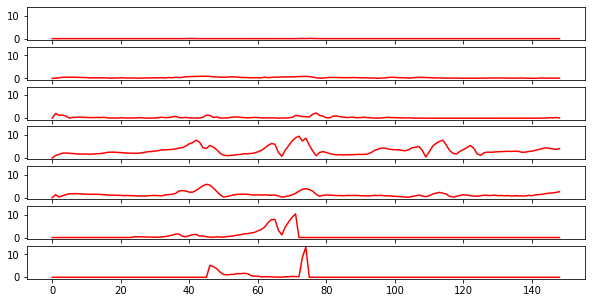

In [9]:
# We can clearly correlate some velocity segments with the movement too, see component #4
load_vel_vln1 = scipy.io.loadmat(os.path.join(file_path,'segvel_vln1.mat'))['vln1']
fig, axes = plt.subplots(nrows=load_vel_vln1.shape[0], ncols=1, figsize=(10,5), sharey='col')
for ax, row in zip(axes.flatten(), load_vel_vln1):
    ax.plot(row,  'r-')
plt.show()

# Let's get started

----Loading audio and computing spectrogram----
shape of input mixture spectrogram is: (2049, 233)
----Computing NMF to get initial W and H estimates----


C:\Users\ADMIN\Miniconda3\envs\ismir2019\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 100 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


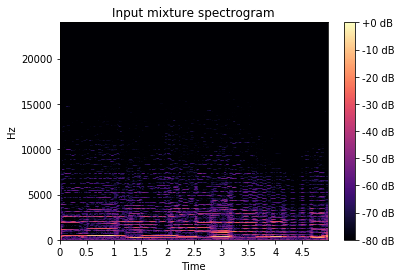

In [4]:
# Get audio representation matrix V from the mixture audio
print('----Loading audio and computing spectrogram----')

# --- Load audio mixture and compute spectrogram
x, sr = librosa.load(audio_path, sr=None)
S = librosa.stft(x, n_fft=n_fft, hop_length=hop_size, window=periodic_hann(n_fft))
V = np.abs(S)
print('shape of input mixture spectrogram is:', V.shape)

if display:
    D = librosa.amplitude_to_db(V, ref=np.max)
    librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr, hop_length=hop_size)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Input mixture spectrogram')

print('----Computing NMF to get initial W and H estimates----')

# --- Perform an NMF decomposition for initializing W and H
nmf_args = {'beta_loss': 'kullback-leibler', 'solver': 'mu', 'max_iter': 100, 'init': 'random'}  
Wini, Hini = librosa.decompose.decompose(V, n_components=K, **nmf_args)

In [5]:
# Construct motion matrix representation

print('----Loading segment velocities for each instrument----')
# --- Load segment velocities 
load_vel_vln1 = scipy.io.loadmat(os.path.join(file_path,'segvel_vln1.mat'))
load_vel_vln2 = scipy.io.loadmat(os.path.join(file_path,'segvel_vln2.mat'))

vel_raw_src1 = load_vel_vln1['vln1']
vel_raw_src2 = load_vel_vln2['vln2']

# --- Resample velocity to match time frames in V
fps = 30
vel_res_src1 = resampy.resample(vel_raw_src1.T, fps, np.ceil(sr/hop_size), axis=0)
vel_res_src2 = resampy.resample(vel_raw_src2.T, fps, np.ceil(sr/hop_size), axis=0)

vel = np.hstack((vel_res_src1, vel_res_src2)) # N x C
vel_src_map = np.hstack((np.ones(vel_raw_src1.shape[0]),2*np.ones(vel_raw_src2.shape[0])))

print('shape of motion matrix is:', vel.shape)


# Initialize cross-modal assignment matrix A
C = vel.shape[1]
Aini = nnrandn((K,C))
print('shape of cross-modal assignment matrix is:', Aini.shape)

----Loading segment velocities for each instrument----
shape of motion matrix is: (233, 12)
shape of cross-modal assignment matrix is: (30, 12)


In [7]:
print('----Performing NMF_NNLS----')
# Perform NMF_NNLS
W, H, A, cost = octave.NMF_NNLS(V, vel, Wini, Hini, Aini, l, mu, niter, nout=4)


print('----Selecting components and reconstructing sources')
# Select components and reconstruct sources using soft mask
component_cluster = vel_src_map[np.argmax(A,axis=1)]

sm_src1 = np.divide(np.matmul(W[:, component_cluster==1],H[component_cluster==1,:]), V)
sm_src2 = np.divide(np.matmul(W[:, component_cluster==2],H[component_cluster==2,:]), V)

stft_src1 = np.multiply(sm_src1,S)
stft_src2 = np.multiply(sm_src2,S)

recon_src1 = librosa.istft(stft_src1, hop_length=hop_size,window=periodic_hann(n_fft))
recon_src2 = librosa.istft(stft_src2, hop_length=hop_size,window=periodic_hann(n_fft))

----Performing NMF_NNLS----
----Selecting components and reconstructing sources


In [8]:
import IPython.display as ipd

print('Reconstructed source 1')
ipd.display(ipd.Audio(recon_src1, rate=sr))

print('Reconstructed source 2')
ipd.display(ipd.Audio(recon_src2, rate=sr))

Reconstructed source 1


Reconstructed source 2
